In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.representations.RealValueEncoder import RealValueEncoder
from lcs.agents.racs import RACS, Configuration
from lcs.metrics import population_metrics
from lcs.agents.racs.metrics import count_averaged_regions

# Load OpenAI environments
import gym
import gym_checkerboard

# rACS in Checkerboard
The following notebook presents the interaction between rACS algorithm and Checkerboard environment.

## Environment
The goal of the _Checkerboard_ environment is to utilize the interval representation.

Instantiate environment using OpenAI Gym interface.

In [2]:
env = gym.make('checkerboard-2D-3div-v0')
env.reset();

Visualize the board

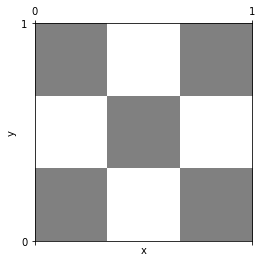

In [3]:
np_board = env.env._board.board

fig = plt.figure()
ax = fig.add_subplot(111)

ax.matshow(np_board, cmap=plt.get_cmap('gray_r'), extent=(0, 1, 0, 1), alpha=.5)
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.show()
fig.savefig("checkerboard_nd3.pdf", bbox_inches='tight')

Each time the environment returns a vector (length is based on the dimensionality) where each allele is a number from 0 to 1. Because rACS uses encoder underneath it's good to know the impact of choosing proper bits for encoding.

Let's declare a helper function encoding such a vector with given bits number.

In [4]:
def encode(p, bits):
    return int(RealValueEncoder(bits).encode(p))

def encode_array(arr, bits):
    return np.fromiter((encode(x, bits=bits) for x in arr), np.int)

In [5]:
a = np.random.random(5)
encode_array(a, bits=2)

array([2, 2, 1, 2, 3])

Checkerboard sample space is divided into regions (with certain amount of splits).

In [6]:
def plot_checkerboard_splits(splits, bits, points=100):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)

    # Visualize splits
    for k in np.linspace(0, 1, splits + 1):
        ax.axvline(x=k, ymin=0, ymax = 1, linewidth=1, linestyle=':', color='black')

    # Add some points
    x = np.random.random(points)
    y = np.random.random(points)
    colors = encode_array(x, bits)
    ax.scatter(x, y, c=colors, s=20, alpha=.8)

    for i, txt in enumerate(colors):
        ax.annotate(txt, xy=(x[i]+.005, y[i]+.005), size=8, alpha=.8)

    ax.set_title(f"{bits}-bit encoder mapping on {splits} checkerboard splits")
    ax.set_xlabel("Perception value")
    ax.set_ylim(-0.2, 1.2)
    ax.get_yaxis().set_visible(False)
    plt.show()

Example: choosing 4-bit encoding would not be sufficient. Values near the first split (x=0.33) are not deterministic.

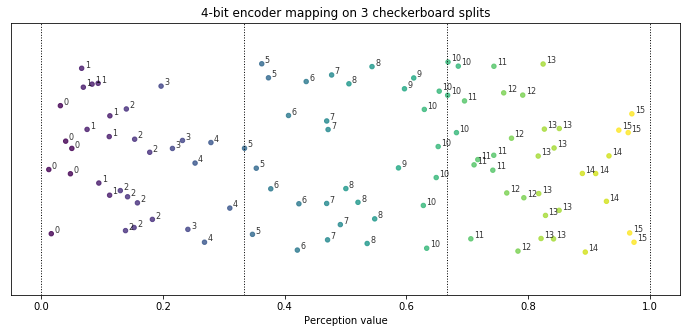

In [7]:
plot_checkerboard_splits(splits=3, bits=4)

Encoding data with 5-bits solves the problem here but is more complicated. The ranges in this case would be defined as follow:
    
    interval_1 = (0, 10]
    interval_2 = (10, 21]
    interval_3 = (21, 31]

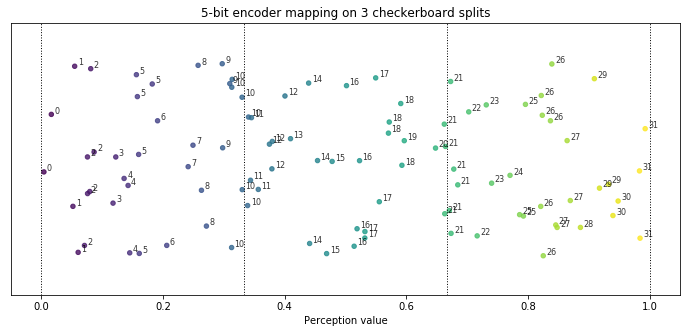

In [8]:
plot_checkerboard_splits(splits=3, bits=5)

## Agent

### Metrics
In order to evaluate the solution region counting metric is defined.

In [9]:
def _checkerboard_metrics(population, environment):
    metrics = {
        'regions': count_averaged_regions(population)
    }

    # Add basic population metrics
    metrics.update(population_metrics(population, environment))

    return metrics

### rACS

In [10]:
ENCODER_BITS = 4

cfg = Configuration(env.observation_space.shape[0], env.action_space.n,
                    encoder=RealValueEncoder(ENCODER_BITS),
                    user_metrics_collector_fcn=_checkerboard_metrics,
                    epsilon=0.9,  # in explore phase explore hard
                    do_ga=True,
                    theta_r=0.9,  # reliablity threshold
                    theta_i=0.3,  # inadequacy threshold
                    theta_ga=100,
                    cover_noise=0.1,
                    mutation_noise=0.25,
                    chi=0.6,  # cross-over probability
                    mu=0.2)  # mutation probability

agent = RACS(cfg)

### Experiment
Perform the experiment in explore-exploit fashion for a number of trials.

In [11]:
%%time

TRIALS = 15_000
population, metrics = agent.explore_exploit(env, TRIALS)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'regions': {1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0}, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 0, 'regions': {1: 0.6435695538057743, 2: 0.23175853018372702, 3: 0.04199475065616798, 4: 0.08267716535433071}, 'population': 2540, 'numerosity': 3823, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 0, 'regions': {1: 0.7105263157894737, 2: 0.18029115341545351, 3: 0.04245987308697275, 4: 0.06672265770810004}, 'population': 3572, 'numerosity': 7149, 'reliable': 1}


CPU times: user 11min 46s, sys: 951 ms, total: 11min 47s
Wall time: 11min 49s


Print reliable classifiers (if any)

In [12]:
reliable = [cl for cl in population if cl.is_reliable()]
reliable = sorted(reliable, key=lambda cl: -cl.fitness)

for cl in reliable[:5]:
    print(cl.condition)
    print(cl.effect)
    print(f"q: {cl.q:.3f}, r: {cl.r:.3f}, exp: {cl.exp}, num: {cl.num}")
    print("\n")

......O...|..O.......|.OO.......
OOOOOOOOOO|OOOOOOOOOO|.........O
q: 0.905, r: 0.939, exp: 25, num: 5


..O.......|O.........|OOOOOOOOOO
OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO
q: 0.908, r: 0.109, exp: 18, num: 17


......O...|..O.......|OOOOOOOOOO
OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO
q: 0.903, r: 0.090, exp: 21, num: 16


.O........|........O.|OOOOOOOOOO
OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO
q: 0.903, r: 0.085, exp: 20, num: 14


.........O|........O.|OOOOOOOOOO
OOOOOOOOOO|OOOOOOOOOO|OOOOOOOOOO
q: 0.911, r: 0.071, exp: 18, num: 16




In [13]:
def parse_metrics(metrics):
    lst = [[
        d['trial'],
        d['population'],
        d['reliable'],
        d['reward'],
        d['regions'][1],
        d['regions'][2],
        d['regions'][3],
        d['regions'][4],
    ] for d in metrics]

    df = pd.DataFrame(lst, columns=['trial', 'population', 'reliable', 'reward', 'region_1', 'region_2', 'region_3', 'region_4'])
    df = df.set_index('trial')

    return df

df = parse_metrics(metrics)
df['mode'] = df.index.map(lambda t: "explore" if t % 2 == 0 else "exploit")
df.head()

,population,reliable,reward,region_1,region_2,region_3,region_4,mode
trial,,,,,,,,
0,1,0,0,0.000000,0.000000,0.0,1.000000,explore
5,2,0,0,0.000000,0.000000,0.0,1.000000,exploit
10,5,0,0,0.000000,0.200000,0.0,0.800000,explore
15,8,0,1,0.125000,0.208333,0.0,0.666667,exploit
20,12,0,1,0.194444,0.250000,0.0,0.555556,explore


Divide the metrics depending on execution mode

In [14]:
explore_df = df[df['mode'] == 'explore']
exploit_df = df[df['mode'] == 'exploit']

### Performance plot

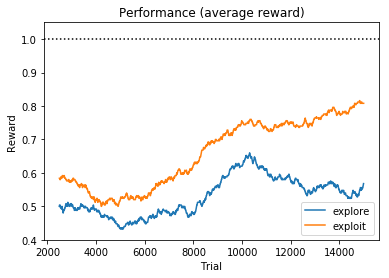

In [15]:
window = 250

fig, ax = plt.subplots()
explore_df['reward'].rolling(window=window).mean().plot(label='explore', ax=ax)
exploit_df['reward'].rolling(window=window).mean().plot(label='exploit', ax=ax)
plt.axhline(1.0, c='black', linestyle=':')

ax.set_title('Performance (average reward)')
ax.set_xlabel('Trial')
ax.set_ylabel('Reward')
ax.set_ylim([.4, 1.05])

plt.legend()
plt.show()

### Condition Interval Regions plot

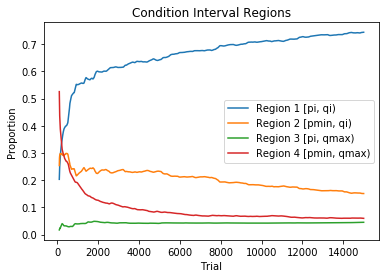

In [16]:
window = 10

fig, ax = plt.subplots()
exploit_df['region_1'].rolling(window=window).mean().plot(label='Region 1 [pi, qi)', ax=ax)
exploit_df['region_2'].rolling(window=window).mean().plot(label='Region 2 [pmin, qi)', ax=ax)
exploit_df['region_3'].rolling(window=window).mean().plot(label='Region 3 [pi, qmax)', ax=ax)
exploit_df['region_4'].rolling(window=window).mean().plot(label='Region 4 [pmin, qmax)', ax=ax)

ax.set_title('Condition Interval Regions')
ax.set_xlabel('Trial')
ax.set_ylabel('Proportion')

plt.legend()
plt.show()

### Numerosity plot

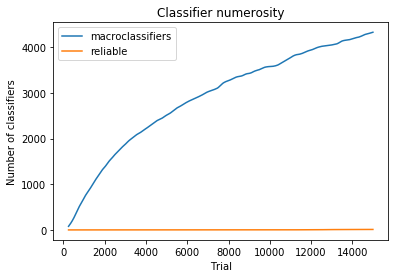

In [17]:
window=50

fig, ax = plt.subplots()
df['population'].rolling(window=window).mean().plot(label='macroclassifiers', ax=ax)
df['reliable'].rolling(window=window).mean().plot(label='reliable', ax=ax)

ax.set_title('Classifier numerosity')
ax.set_xlabel('Trial')
ax.set_ylabel('Number of classifiers')

plt.legend()
plt.show()

fig.savefig("foo2.pdf", bbox_inches='tight')